In [ ]:
# python3 autoregressive/sample/sample_t2i.py --vq-ckpt ./pretrained_models/vq_ds16_t2i.pt --gpt-ckpt ./pretrained_models/t2i_XL_stage2_512.pt --gpt-model GPT-XL --image-size 512

In [ ]:
import os
import json
from tqdm import tqdm
from multiprocessing import Pool, Manager

# Define the root paths
root_paths = [
    "/nobackup/zefan/projects/VLGen/segment_results_imgnet",
    "/nobackup/zefan/projects/VLGen/segment_results_sam_molom",
    "/nobackup/zefan/projects/VLGen/segment_results_sam",
]

# Output file
output_file = "/nobackup/zefan/projects/VLGen/LlamaGen/metadata_all.jsonl"

# Function to recursively find and process metadata.jsonl
def find_and_process_metadata(folder):
    metadata_list = []
    for root, _, files in tqdm(os.walk(folder)):
        if "metadata.jsonl" in files:
            metadata_path = os.path.join(root, "metadata.jsonl")
            with open(metadata_path, 'r') as f:
                for line in f:
                    metadata_list.append(json.loads(line.strip()))
    return metadata_list

# Function to collect metadata using multiprocessing
def collect_metadata(folder):
    try:
        return find_and_process_metadata(folder)
    except Exception as e:
        print(f"Error processing folder {folder}: {e}")
        return []

if __name__ == "__main__":
    all_metadata = []
    
    # Use multiprocessing for faster traversal
    with Manager() as manager:
        metadata_list = manager.list()
        with Pool(processes=os.cpu_count()) as pool:
            results = list(tqdm(pool.imap(collect_metadata, root_paths), total=len(root_paths)))
        
        # Combine results into a single list
        for result in results:
            all_metadata.extend(result)
    
    # Save all metadata to a single JSONL file
    with open(output_file, 'w') as out_f:
        for item in all_metadata:
            out_f.write(json.dumps(item) + '\n')

    print(f"Metadata collected and saved to {output_file}")


In [29]:
from collections import Counter  
from multiprocessing import Manager  
import json
import os
from tqdm import tqdm
from PIL import Image
import numpy as np
from multiprocessing import Pool, cpu_count
import numpy as np
from scipy.ndimage import label
# Paths
input_file = "/nobackup/zefan/projects/VLGen/LlamaGen/metadata_all.jsonl"
output_file_correct = "/nobackup/zefan/projects/VLGen/LlamaGen/metadata_correct.jsonl"
output_file_incorrect = "/nobackup/zefan/projects/VLGen/LlamaGen/metadata_incorrect.jsonl"
def is_similar(img1, img2, threshold=0.95, resize_dim=(32, 32)):
    """
    Check if two images are similar by resizing, scaling back, and comparing pixel values.

    Args:
        img1, img2: PIL Image objects to compare.
        threshold: Similarity threshold (default is 0.95).
        resize_dim: Dimensions to resize the images to (default is 32x32).

    Returns:
        bool: True if images are similar, False otherwise.
    """
    # Resize and scale back to original size
    resized_img1 = img1.resize(resize_dim, Image.Resampling.LANCZOS)
    resized_img2 = img2.resize(resize_dim, Image.Resampling.LANCZOS)

    # Flatten and compare pixel arrays
    arr1 = np.array(resized_img1).flatten()
    arr2 = np.array(resized_img2).flatten()

    # Compute similarity
    return np.mean(arr1 == arr2) >= threshold
def is_scattered(mask_path, min_connected_area=5, max_components=1000):
    """
    检测 mask 是否为散点失败。

    Args:
        mask_path (str): mask 图片路径。
        min_connected_area (int): 单个连通区域的最小像素数，低于此值认为是散点。
        max_components (int): 最大允许的连通区域数量，超过此值认为是散点。
    
    Returns:
        bool: 如果是散点情况，返回 True；否则返回 False。
    """
    # 加载图片并转换为二值化数组
    mask = Image.open(mask_path).convert("L")
    mask_array = np.array(mask) > 0  # 转换为布尔值，True 表示非零像素

    # 计算连通域
    labeled_array, num_features = label(mask_array)

    # 统计连通域面积
    component_sizes = np.bincount(labeled_array.ravel())[1:]  # 排除背景（label=0）

    # 判断是否为散点
    scattered = (
        len(component_sizes) > max_components or  # 连通域数量过多
        all(size < min_connected_area for size in component_sizes)  # 所有区域都过小
    )
    return scattered
# Modify is_mask_valid to return a reason  
def is_mask_valid(mask_paths):  
    if len(mask_paths) == 1:  
        return True, None  # Single mask is always valid  
    elif len(mask_paths) == 0:  
        return False, "no_masks"  

    # Load masks  
    masks = [Image.open(path) for path in mask_paths]  
    mask_sizes = [np.sum(np.array(mask) > 0) for mask in masks]  
    total_pixels = masks[0].size[0] * masks[0].size[1]  

    # Check similarity  
    for path in mask_paths:
        if is_scattered(path):
            return False, "scattered_masks" 

    for i, mask1 in enumerate(masks):  
        for j, mask2 in enumerate(masks):  
            if i < j and is_similar(mask1, mask2):  # Check similarity  
                return False, "similar_masks"  

    # Check size condition  
    for size in mask_sizes:  
        ratio = size / total_pixels  
        if ratio < 0.003:  
            return False, "mask_too_small"  
        if ratio > 0.95:  
            return False, "mask_too_large"  

    return True, None  

# Process a single JSON entry  
def process_line(line):  
    data = json.loads(line)  
    mask_paths = data["mask_path"]  

    is_valid, reason = is_mask_valid(mask_paths)  
    if is_valid:  
        return "correct", data, None  
    else:  
        return "incorrect", data, reason  

def process_file():  
    with open(input_file, "r") as f:  
        lines = f.readlines()  

    correct_cases = []  
    incorrect_cases = []  
    
    # Initialize reason counter  
    reason_counter = Counter()  

    with Pool(cpu_count()) as pool:  
        results = list(tqdm(pool.imap(process_line, lines), total=len(lines)))  

    for result_type, data, reason in results:  
        if result_type == "correct":  
            correct_cases.append(data)  
        else:  
            incorrect_cases.append(data)  
            reason_counter[reason] += 1  

    # Save results  
    with open(output_file_correct, "w") as f_correct, open(output_file_incorrect, "w") as f_incorrect:  
        for case in correct_cases:  
            f_correct.write(json.dumps(case) + "\n")  
        for case in incorrect_cases:  
            f_incorrect.write(json.dumps(case) + "\n")  

    # Print the number of detected issues  
    print(f"Total correct cases: {len(correct_cases)}")  
    print(f"Total incorrect cases: {len(incorrect_cases)}")  
    print("Reasons for incorrectness:")  
    for reason, count in reason_counter.items():  
        print(f"{reason}: {count}")  

process_file()

100%|██████████| 469418/469418 [02:44<00:00, 2850.13it/s]


Total correct cases: 361253
Total incorrect cases: 108165
Reasons for incorrectness:
similar_masks: 69745
mask_too_small: 11648
scattered_masks: 22238
mask_too_large: 4510
no_masks: 24


In [1]:
import json
import random

# Paths
input_file = "/nobackup/zefan/projects/VLGen/LlamaGen/metadata_correct.jsonl"
output_val_file = "/nobackup/zefan/projects/VLGen/LlamaGen/new_1117_validation_set.jsonl"
output_train_file = "/nobackup/zefan/projects/VLGen/LlamaGen/new_1117_train_set.jsonl"

# Load the input JSONL file
with open(input_file, "r") as f:
    data = [json.loads(line.strip()) for line in f]

# Randomly split 500 samples for validation, rest for training
random.seed(42)  # For reproducibility
random.shuffle(data)
val_data = data[:500]
train_data = data[500:]

# Function to convert data format
def convert_to_new_format(data, starting_idx=0):
    new_data = []
    global_idx = starting_idx
    for item in data:
        for segment_idx, (mask_path, obj) in enumerate(zip(item["mask_path"], item["sam_objects"])):
            new_sample = {
                "global_idx": global_idx,
                "source_image": item["source_img"],
                "image_path": mask_path,
                "objects": obj,
                "segment_idx": segment_idx,
                "input_text": f"<image>\n{item['caption']}"
            }
            new_data.append(new_sample)
            global_idx += 1
    return new_data

# Convert validation and training data
val_converted = convert_to_new_format(val_data, starting_idx=0)
train_converted = convert_to_new_format(train_data, starting_idx=len(val_converted))

# Save converted data to new JSONL files
with open(output_val_file, "w") as val_out, open(output_train_file, "w") as train_out:
    for item in val_converted:
        val_out.write(json.dumps(item) + "\n")
    for item in train_converted:
        train_out.write(json.dumps(item) + "\n")

# Summary
len(val_converted), len(train_converted)


(1066, 766167)

In [2]:
train_converted[0]

{'global_idx': 1066,
 'source_image': '/nobackup/zefan/projects/VLGen/segment_results_sam/cnt_10000_1000000000_0_39_0/0000000706/ori.jpg',
 'image_path': '/nobackup/zefan/projects/VLGen/segment_results_sam/cnt_10000_1000000000_0_39_0/0000000706/mask_bride.jpg',
 'objects': 'bride',
 'segment_idx': 0,
 'input_text': '<image>\nA bride being photographed on a scenic dock surrounded by decorative arches.'}

In [16]:


mask_paths= ["/nobackup/zefan/projects/VLGen/segment_results_imgnet/cnt_0_100000000_0_2_0/0000000331/mask_wardrobe.jpg", "/nobackup/zefan/projects/VLGen/segment_results_imgnet/cnt_0_100000000_0_2_0/0000000331/mask_clothes.jpg", "/nobackup/zefan/projects/VLGen/segment_results_imgnet/cnt_0_100000000_0_2_0/0000000331/mask_drawer.jpg"]
def is_mask_valid(mask_paths):  
    if len(mask_paths) == 1:  
        return True, None  # Single mask is always valid  
    elif len(mask_paths) == 0:  
        return False, "no_masks"  

    # Load masks  
    masks = [Image.open(path) for path in mask_paths]  
    mask_sizes = [np.sum(np.array(mask) > 0) for mask in masks]  
    total_pixels = masks[0].size[0] * masks[0].size[1]  

    # Check similarity  
    # for i, mask1 in enumerate(masks):  
    #     for j, mask2 in enumerate(masks):  
    #         if i < j and is_similar(mask1, mask2):  # Check similarity  
    #             return False, "similar_masks"  

    # Check size condition  
    for i, size in enumerate(mask_sizes):  
        ratio = size / total_pixels  
        if ratio < 0.05:  
            return False, "mask_too_small" ,masks ,i
        # if ratio > 0.95:  
        #     return False, "mask_too_large"  

    return True, None  

_,_,masks,i = is_mask_valid(mask_paths)

In [17]:
 masks[0].size[0] * masks[0].size[1]  

262144

In [37]:
np.sum(np.array(mask[1]) == 0)

254807

In [17]:
from PIL import Image, ImageDraw  
import numpy as np  

def create_image_with_polygon(p):  
    # 确保 p 值在 0 到 100 之间  
    if not (0 <= p <= 100):  
        raise ValueError("p must be between 0 and 100")  
    
    # 图像大小  
    size = (512, 512)  
    total_pixels = size[0] * size[1]  
    
    # 计算应该变白的像素数  
    white_pixels_count = int(total_pixels * (p / 100.0))  

    # 创建一个黑色的图像  
    image = Image.new("L", size, 0)  
    draw = ImageDraw.Draw(image)  
    
    # 选择一个简单的正六边形作为多边形  
    num_sides = 6  
    
    # 初步假设使用一个大小足够大的中心多边形, 然后调整以适应p%  
    # 这里假设使用边长和几何方法计算所需面积后调整  
    # 考虑正多边形面积公式: (3*np.sqrt(3)*(edge_length**2))/2  
    approx_edge_length = np.sqrt((2 * white_pixels_count) / (3 * np.sqrt(3)))  

    # 将多边形设置在图像的中心  
    center_x, center_y = size[0] // 2, size[1] // 2  
    angle_step = 360 / num_sides  
    
    # 创建多边形顶点  
    points = [  
        (  
            center_x + approx_edge_length * np.cos(np.radians(angle_step * i)),  
            center_y + approx_edge_length * np.sin(np.radians(angle_step * i))  
        )  
        for i in range(num_sides)  
    ]  

    # 画多边形  
    draw.polygon(points, fill=255)  

    return image  

# 使用示例：创建一个图像，中间是面积为30% 的白色多边形  
polygon_image = create_image_with_polygon(95)  

In [ ]:
# convert dreambench_plus
import os
import json

# Define input and output paths
base_path = "/nobackup/zefan/projects/VLGen/LlamaGen"
captions_folder = os.path.join(base_path, "data/captions")
images_folder = os.path.join(base_path, "data/images")
output_file = os.path.join(base_path, "dreambench_plus_valid.jsonl")

# Initialize global_idx and list to store dataset
global_idx = 0
dataset = []

# Traverse the captions folder
for root, _, files in os.walk(captions_folder):
    for file in files:
        if file.endswith(".txt"):
            txt_path = os.path.join(root, file)
            image_relative_path = os.path.relpath(root, captions_folder)
            image_file = file.replace(".txt", ".jpg")
            image_path = os.path.join(images_folder, image_relative_path, image_file)
            
            # Read the txt file
            with open(txt_path, 'r') as f:
                lines = f.readlines()
                if len(lines) > 1:
                    object_name = lines[0].strip()
                    captions = [line.strip() for line in lines[1:]]
                    
                    # Create dataset instances for each caption
                    for caption in captions:
                        instance = {
                            "global_idx": global_idx,
                            "source_image": image_path,
                            "image_path": image_path,
                            "objects": object_name,
                            "segment_idx": 0,
                            "input_text": f"<image>\n{caption}"
                        }
                        dataset.append(instance)
                        global_idx += 1

# Save the dataset to a jsonl file
with open(output_file, 'w') as f:
    for entry in dataset:
        json.dump(entry, f)
        f.write("\n")

# Confirm completion
output_file


'/nobackup/zefan/projects/VLGen/LlamaGen/dreambench_plus_valid.jsonl'

In [3]:
import pickle
import torch
# load /home/jovyan/MLLMG/output.tensor
# open pickle
with open('/home/jovyan/MLLMG/output.tensor', 'rb') as f:
    output = pickle.load(f)
with open('/home/jovyan/MLLMG/outputv2.tensor', 'rb') as f:
    outputv2 = pickle.load(f)

In [44]:
torch.where(output[0][0,:120].sum(1) == 0
)

(tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
         18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35,
         36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53,
         54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71,
         72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89,
         90, 91, 92, 93, 94], device='cuda:0'),)

In [33]:
torch.split(outputv2[1][0], 20)

(tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        device='cuda:0', dtype=torch.bfloat16, grad_fn=<SplitBackward0>),
 tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        device='cuda:0', dtype=torch.bfloat16, grad_fn=<SplitBackward0>),
 tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        device='cuda:0', dtype=torch.bfloat16, grad_fn=<SplitBackward0>),
 tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        device='cuda:0', dtype=torch.bfloat16, grad_fn=<SplitBackward0>),
 tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        device='cuda:0', dtype=torch.bfloat16, grad_fn=<SplitBackward0>),
 tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        device='cuda:0', dtype=torch.bfloat16, grad_fn=<SplitBackward0>),
 tensor([0., 0.,

In [25]:
torch.where(outputv2[2].sum(1) == 0
)

(tensor([], device='cuda:0', dtype=torch.int64),)

In [ ]:
import os
import json
import concurrent.futures
import multiprocessing
from tqdm import tqdm

# 定义要搜索的文件夹路径
folders = [
    "/tmp/haozhezhao/data/segment_results_imgnet",
    "/tmp/haozhezhao/data/segment_results_sam_molom",
    "/tmp/haozhezhao/VL_Prompt/segment_results_FLUX_molom_start_500000_end_600000",
    "/tmp/haozhezhao/VL_Prompt/segment_results_FLUX_molom_start_600000_end_700000",
    "/tmp/haozhezhao/VL_Prompt/segment_results_FLUX_molom_start_700000_end_800000",
    "/tmp/haozhezhao/VL_Prompt/segment_results_FLUX_molom_start_900000_end_950000",
]

# 目标 JSONL 文件路径
output_jsonl_path = "/tmp/haozhezhao/MLLMG/jsonl_data/merged_segment_results.jsonl"

# 额外需要合并的 JSONL 文件路径
extra_jsonl_path = "/tmp/haozhezhao/data/flux_segment/flux_segment_images.jsonl"

def find_metadata_files(folder):
    """
    使用 os.walk 遍历给定文件夹，查找所有名为 metadata.jsonl 的文件
    """
    metadata_files = []
    for root, dirs, files in os.walk(folder):
        for file in files:
            if file == 'metadata.jsonl':
                metadata_files.append(os.path.join(root, file))
    return metadata_files

# 利用多进程对每个文件夹进行并行查找
with multiprocessing.Pool(processes=len(folders)) as pool:
    results = pool.map(find_metadata_files, folders)
# 将所有查找到的文件列表合并为一个列表
jsonl_files = [file for sublist in results for file in sublist]

def process_jsonl_file(file_path):
    """
    读取单个 JSONL 文件，并提取所需字段
    """
    results = []
    try:
        with open(file_path, "r") as f:
            for line in f:
                data = json.loads(line.strip())
                # 根据数据格式提取所需字段
                if "input_image" in data:
                    extracted = {
                        "prompt": data.get("caption", ""),
                        "source_img": data.get("source_img", ""),
                        "sam_objects": data.get("sam_objects", []),
                        "mask_path": data.get("mask_path", [])
                    }
                else:
                    extracted = {
                        "prompt": data.get("prompt", ""),
                        "source_img": data.get("source_img", ""),
                        "sam_objects": data.get("sam_objects", []),
                        "mask_path": data.get("mask_path", [])
                    }
                results.append(extracted)
    except Exception as e:
        print(f"Error processing {file_path}: {e}")
    return results

# 使用多线程并发处理所有 JSONL 文件，利用 tqdm 显示进度（不设置 total 参数）
merged_data = []
with concurrent.futures.ThreadPoolExecutor(max_workers=8) as executor:
    for file_result in tqdm(executor.map(process_jsonl_file, jsonl_files), desc="Processing files"):
        merged_data.extend(file_result)

# 处理额外的 JSONL 文件
merged_data.extend(process_jsonl_file(extra_jsonl_path))

# 保存合并后的数据到输出文件
with open(output_jsonl_path, "w") as out_file:
    for entry in merged_data:
        out_file.write(json.dumps(entry) + "\n")

print(output_jsonl_path)


In [4]:
import json
from tqdm import tqdm
# 定义文件路径
file_path = "/tmp/haozhezhao/MLLMG/jsonl_data/merged_segment_results.jsonl"

# 存储符合条件的案例
filtered_cases = []

# 逐行读取 JSONL 文件并筛选符合条件的数据
with open(file_path, "r", encoding="utf-8") as f:
    for line in tqdm(f):
        data = json.loads(line.strip())  # 解析 JSON
        if "source_img" in data and "VL_Prompt" in data["source_img"]:
            filtered_cases.append(data)


1255733it [00:06, 190804.17it/s]


In [10]:
len(mask_gt_3)

16

In [1]:
import json
import random
from tqdm import tqdm

# 文件路径
merged_jsonl_path = "/tmp/haozhezhao/MLLMG/jsonl_data/merged_segment_results.jsonl"
val_jsonl_path = "/tmp/haozhezhao/MLLMG/jsonl_data/merged_segment_results_val.jsonl"
train_jsonl_path = "/tmp/haozhezhao/MLLMG/jsonl_data/merged_segment_results_trained.jsonl"

# 读取 JSONL 数据
records = []
with open(merged_jsonl_path, "r") as f:
    for line in tqdm(f, desc="Loading JSONL data"):
        records.append(json.loads(line.strip()))

# 打乱数据，提高随机性
random.shuffle(records)

# 存储验证集和训练集
val_records = []
train_records = []

# 遍历数据并分类
for rec in records:
    source_img = rec.get("source_img", "")
    mask_len = len(rec.get("mask_path", []))

    if "VL_Prompt" in source_img and mask_len > 1 and len(val_records) < 300:
        val_records.append(rec)  # 选入验证集
    elif "VL_Prompt" not in source_img and mask_len == 3 and len(val_records) < 500:
        val_records.append(rec)  # 选入验证集
    else:
        train_records.append(rec)  # 其余数据存入训练集

# 再次打乱数据
random.shuffle(val_records)
random.shuffle(train_records)

# 保存验证集
with open(val_jsonl_path, "w") as f:
    for record in tqdm(val_records, desc="Saving Validation JSONL"):
        f.write(json.dumps(record) + "\n")

# 保存训练集
with open(train_jsonl_path, "w") as f:
    for record in tqdm(train_records, desc="Saving Training JSONL"):
        f.write(json.dumps(record) + "\n")

print(f"Validation set saved to: {val_jsonl_path} (Total: {len(val_records)})")
print(f"Training set saved to: {train_jsonl_path} (Total: {len(train_records)})")


Loading JSONL data: 1255733it [00:11, 110952.49it/s]
Saving Training JSONL: 100%|██████████| 1255233/1255233 [00:08<00:00, 149193.85it/s]

Validation set saved to: /tmp/haozhezhao/MLLMG/jsonl_data/merged_segment_results_val.jsonl (Total: 500)
Training set saved to: /tmp/haozhezhao/MLLMG/jsonl_data/merged_segment_results_trained.jsonl (Total: 1255233)


In [3]:
import json
from tqdm import tqdm

# 文件路径设置
merged_jsonl_path = "/tmp/haozhezhao/MLLMG/jsonl_data/merged_segment_results_val.jsonl"
new_jsonl_path = "/tmp/haozhezhao/MLLMG/jsonl_data/multiobjects_molom_imagenet_flux_sam_1_2m_val.jsonl" 

# 替换规则
old_prefix = "/nobackup/zefan/projects/VLGen/"
new_prefix = "/tmp/haozhezhao/data/"

# 第一步：加载原始 JSONL 文件并进行替换
updated_records = []
with open(merged_jsonl_path, "r") as f:
    lines = f.readlines()

for line in tqdm(lines, desc="Replacing paths in JSONL"):
    record = json.loads(line.strip())
    # 替换 source_img 中的路径
    if "source_img" in record and isinstance(record["source_img"], str):
        record["source_img"] = record["source_img"].replace(old_prefix, new_prefix)
    # 替换 mask_path 列表中每个路径
    if "mask_path" in record and isinstance(record["mask_path"], list):
        record["mask_path"] = [p.replace(old_prefix, new_prefix) if isinstance(p, str) else p for p in record["mask_path"]]
    updated_records.append(record)

# 将替换后的数据覆盖保存到原文件
with open(merged_jsonl_path, "w") as f:
    for record in tqdm(updated_records, desc="Saving updated JSONL"):
        f.write(json.dumps(record) + "\n")

# 第二步：构造新的 JSONL 数据
new_records = []
for idx, rec in tqdm(enumerate(updated_records), total=len(updated_records), desc="Constructing new JSONL"):
    new_record = {
        "global_idx": idx,
        "source_image": rec.get("source_img", ""),
        "image_path": rec.get("mask_path", []),
        "objects": rec.get("sam_objects", []),
        "segment_idx": 0,
        "input_text": rec.get("prompt", ""),
        "generation_only": False,
        "do_mask": False,
        "do_replace": False
    }
    new_records.append(new_record)

# 将新的 JSONL 数据保存到目标文件
with open(new_jsonl_path, "w") as f:
    for record in tqdm(new_records, desc="Saving new JSONL file"):
        f.write(json.dumps(record) + "\n")

print("更新后的 merged JSONL 已保存到:", merged_jsonl_path)
print("新构建的 JSONL 文件已保存到:", new_jsonl_path)


Saving updated JSONL: 100%|██████████| 500/500 [00:00<00:00, 164844.52it/s]


Saving new JSONL file: 100%|██████████| 500/500 [00:00<00:00, 157408.39it/s]

更新后的 merged JSONL 已保存到: /tmp/haozhezhao/MLLMG/jsonl_data/merged_segment_results_val.jsonl
新构建的 JSONL 文件已保存到: /tmp/haozhezhao/MLLMG/jsonl_data/multiobjects_molom_imagenet_flux_sam_1_2m_val.jsonl


In [1]:
import torch._dynamo
torch._dynamo.config.suppress_errors = True
from textwrap import fill
import torch
import socket
import wandb
# torch._dynamo.config.capture_scalar_outputs = True
torch.backends.cuda.matmul.allow_tf32 = True
torch.backends.cudnn.allow_tf32 = True
from tqdm import tqdm
import torch.distributed as dist
from torch.nn.parallel import DistributedDataParallel as DDP
from torch.utils.data import DataLoader
from torch.utils.data.distributed import DistributedSampler
from torchvision import transforms
from glob import glob
from transformers import BertTokenizer
import time
import argparse
import os
from torch.nn.utils.rnn import pad_sequence  
import torch.nn.functional as F
from utils.distributed import init_distributed_mode
from utils.logger import create_logger
from dataset.build import build_dataset
from dataset.augmentation import center_crop_arr
from autoregressive.train.train_c2i import creat_optimizer
from autoregressive.models.gpt import GPT_models
from autoregressive.models.ori_gpt import GPT_models as GPT_models_ori
from autoregressive.models.empty_fix_gpt import GPT_models as GPT_models_empty
from tokenizer.tokenizer_image.vq_model import VQ_models
from autoregressive.models.generate import generate
from torchvision.utils import save_image
from transformers.modeling_utils import PreTrainedModel, load_sharded_checkpoint
from scheduler import AnnealingLR
import random
import numpy as np
from PIL import Image, ImageDraw, ImageFont

GPT_MODEL = {
    'gpt': GPT_models_ori,
    'gpt-empty-fix': GPT_models_empty,
    'gpt-zero-fix' : GPT_models
}


device = torch.device("cuda:0")


# ========= 工具函数 =========
from transformers import BertTokenizer

def process_text_info(each, args):
    """
    根据 objects 构造文本输入，并利用 BertTokenizer 得到文本 token 信息
    """
    qformer_tokenizer = BertTokenizer.from_pretrained("bert-base-uncased", truncation_side="right")
    qformer_tokenizer.add_special_tokens({"bos_token": "[DEC]"})
    if args.multimodal_encoder == 'llava':
        image_place_holder_num = 256
    else:
        image_place_holder_num = 32
    image_place_holder = "".join([args.image_place_holder] * image_place_holder_num)
    
    input_text = each['input_text'].replace(args.image_place_holder, "").strip()
    objects = each['objects']
    qformer_inputs = qformer_tokenizer(objects, return_tensors="pt", padding=True)
    text_input_ids = qformer_inputs['input_ids']
    text_attention_mask = qformer_inputs['attention_mask']
    input_prefix = "\n".join([f"The {obj} in {image_place_holder}." for obj in objects])
    input_text = input_prefix + "\n" + input_text
    return input_text, text_input_ids, text_attention_mask

def load_image(img_path):
    try:
        img = Image.open(img_path).convert("RGB")
        img = img.resize((512, 512), Image.BICUBIC)
        return img
    except Exception as e:
        print(f"Error loading image {img_path}: {e}")
        return Image.new('RGB', (512, 512), (255, 255, 255))
def resize_to_square(image):
    """
    将 image 调整为正方形，新尺寸为原图最长边，
    空白区域用黑色填充
    """
    width, height = image.size
    new_size = max(width, height)
    # 创建黑色背景的新图像
    new_image = Image.new("RGB", (new_size, new_size), (0, 0, 0))
    # 计算原图粘贴到新图像的左上角位置，使其居中
    left = (new_size - width) // 2
    top = (new_size - height) // 2
    new_image.paste(image, (left, top))
    return new_image

def process_objects(each):
    """
    加载 source image 以及 mask 图片列表
    """
    img_paths = each['image_path']
    source_path = each['source_image']
    images = []
    for item in img_paths:
        img = load_image(item).convert("RGB")
        img = resize_to_square(img)
        images.append(img)
    source_image = load_image(source_path)
    return source_image, images

# ========= 参数设置 =========
# 注意：下面的默认值已经参考了你的训练脚本示例参数
parser = argparse.ArgumentParser()
parser.add_argument("--data-path", type=str, default="data/test_data")
parser.add_argument("--cloud-save-path", type=str, default="/tmp/haozhezhao/MLLMG/", help='please specify a cloud disk path, if not, local path')
parser.add_argument("--no-local-save", action='store_true')
parser.add_argument("--vq-model", type=str, choices=["VQ-16"], default="VQ-16")
parser.add_argument("--vq-ckpt", type=str, default="/tmp/haozhezhao/model/llamagen_t2i/vq_ds16_t2i.pt", help="ckpt path for vq model")
parser.add_argument("--codebook-size", type=int, default=16384)
parser.add_argument("--codebook-embed-dim", type=int, default=8)
parser.add_argument("--gpt-model", type=str, choices=["GPT-XL"], default="GPT-XL")
parser.add_argument("--gpt-ckpt", type=str, default="/tmp/haozhezhao/MLLMG/checkpoint/zeroFix_InstructBlip_just_segment_pretrain_stage3_multiobjects_no_overlap/010-GPT-XL/checkpoints/0008000.pt", help="ckpt path for resume training")
parser.add_argument("--gpt-type", type=str, choices=['c2i', 't2i'], default="t2i")
parser.add_argument("--vocab-size", type=int, default=16384)
parser.add_argument("--cls-token-num", type=int, default=120)
parser.add_argument("--dropout-p", type=float, default=0.1)
parser.add_argument("--token-dropout-p", type=float, default=0.1)
parser.add_argument("--drop-path", type=float, default=0.0)
parser.add_argument("--no-compile", action='store_true')
parser.add_argument("--results-dir", type=str, default="results/test")
parser.add_argument("--dataset", type=str, default='ti2i')
parser.add_argument("--image-size", type=int, choices=[256, 384, 512], default=512)
parser.add_argument("--downsample-size", type=int, choices=[8, 16], default=16)
parser.add_argument("--num-classes", type=int, default=1000)
parser.add_argument("--epochs", type=int, default=5)
parser.add_argument("--lr", type=float, default=1e-4)
parser.add_argument("--weight-decay", type=float, default=5e-2)
parser.add_argument("--beta1", type=float, default=0.9)
parser.add_argument("--beta2", type=float, default=0.95)
parser.add_argument("--max-grad-norm", default=1.0, type=float)
parser.add_argument("--global-batch-size", type=int, default=36)
parser.add_argument("--global-seed", type=int, default=0)
parser.add_argument("--num-workers", type=int, default=8)
parser.add_argument("--log-every", type=int, default=25)
parser.add_argument("--ckpt-every", type=int, default=1000)
parser.add_argument("--gradient-accumulation-steps", type=int, default=4)
parser.add_argument("--mixed-precision", type=str, default='bf16', choices=["none", "fp16", "bf16"])
parser.add_argument("--val_data_path", type=str, default="data/val_data")
parser.add_argument("--use_vision_tower", action='store_true', default=True)
parser.add_argument("--model_name_or_path", type=str, default="/tmp/haozhezhao/model/instructblip-flan-t5-xl")
parser.add_argument("--image_place_holder", type=str, default="<image>")
parser.add_argument("--processor_path", type=str, default=None)
parser.add_argument("--do_eval", action='store_true', default=True)
parser.add_argument("--max_eval_samples", type=int, default=256)
parser.add_argument("--train_text_encoder", action='store_true', default=True)
parser.add_argument("--no-left-padding", action='store_true', default=False)
parser.add_argument("--cfg-scale", type=float, default=1.5)
parser.add_argument("--top-k", type=int, default=16384)
parser.add_argument("--temperature", type=float, default=0.9)
parser.add_argument("--top-p", type=float, default=1.0)
parser.add_argument("--eval_steps", type=int, default=1000)
parser.add_argument("--project_name", type=str, default='llamagen_ti2i')
parser.add_argument("--load_from_checkpoint", type=str, default=None)
parser.add_argument('--warmup', type=float, default=0.05)
parser.add_argument('--lr-decay-style', type=str, default='cosine', choices=['constant', 'linear', 'cosine', 'exponential'])
parser.add_argument('--lr-decay-ratio', type=float, default=0.1)
parser.add_argument('--train-iters', type=int, default=500000)
parser.add_argument("--class-dropout-prob", type=float, default=0.1)
parser.add_argument("--with_image_only", action='store_true')
parser.add_argument("--image_only_rate", type=float, default=0.1)
parser.add_argument("--stage2", action='store_true')
parser.add_argument("--subject_driven", action='store_true', default=True)
parser.add_argument("--load_subject_embedding", type=str, default=None)
parser.add_argument("--multimodal_encoder", type=str, default="instructblip")
parser.add_argument("--load_visual_encoder", action='store_true', default=False)
parser.add_argument("--mm_vision_tower", type=str, default="openai/clip-vit-large-patch14")
parser.add_argument("--fix", type=str, choices=["gpt","gpt-zero-fix", "gpt-empty-fix"], default="gpt-zero-fix")

# 对于 jupyter 测试，使用空列表传入解析器（即采用所有默认值）
args = parser.parse_args([])
latent_size = args.image_size // args.downsample_size

# print("当前参数：")
# for k, v in vars(args).items():
#     print(f"{k}: {v}")

# ========= 模拟输入数据 =========
# 为测试准备一个 dummy 的 each 数据字典，同时生成一些测试图片



# ========= 测试流程 =========

    



/tmp/haozhezhao/anaconda3/envs/nlp/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
with torch.no_grad():
    # 根据 fix 类型和 gpt-model 参数初始化模型（使用 dummy 实现）
    eval_model = GPT_MODEL[args.fix][args.gpt_model](
        vocab_size=args.vocab_size,
        block_size=latent_size ** 2,
        num_classes=args.num_classes,
        cls_token_num=args.cls_token_num,
        model_type=args.gpt_type,
        resid_dropout_p=args.dropout_p,
        ffn_dropout_p=args.dropout_p,
        token_dropout_p=args.token_dropout_p,
        class_dropout_prob=args.class_dropout_prob,
        use_vision_tower=args.use_vision_tower,
        latent_size=latent_size,
        model_name_or_path=args.model_name_or_path,
        mixed_precision=args.mixed_precision,
        image_place_holder=args.image_place_holder,
        processor_path=args.processor_path,
        max_seq_length=args.cls_token_num,
        multimodal_encoder=args.multimodal_encoder,
        mm_vision_tower=args.mm_vision_tower
    )
    
    try:
        model_weight = torch.load(args.gpt_ckpt, map_location='cpu')['model']
        eval_model.load_state_dict(model_weight, strict=True)
    except Exception as e:
        print("加载 checkpoint 时出错，跳过：", e)
    
    ptdtype = {'none': torch.float32, 'bf16': torch.bfloat16, 'fp16': torch.float16}[args.mixed_precision]
    eval_model = eval_model.to(device, ptdtype, non_blocking=True)
    eval_model.eval()

    vq_model = VQ_models[args.vq_model](
    codebook_size=args.codebook_size,
    codebook_embed_dim=args.codebook_embed_dim)
    vq_model.eval()
    checkpoint = torch.load(args.vq_ckpt, map_location="cpu")
    vq_model.load_state_dict(checkpoint["model"])
    vq_model = vq_model.to(device, ptdtype, non_blocking=True)

model_name_or_path:/tmp/haozhezhao/model/instructblip-flan-t5-xl


image_place_holder: <image>
tokenizer length after expend 32102
tokenizer length before expend 32102


/tmp/ipykernel_4137530/2812168427.py:25: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_weight = torch.load(args.gpt_ckpt, map_location='cpu')['model']
/tmp/ipykernel_4

processing left-padding...


0it [00:00, ?it/s]

图片已保存为test3_0.png


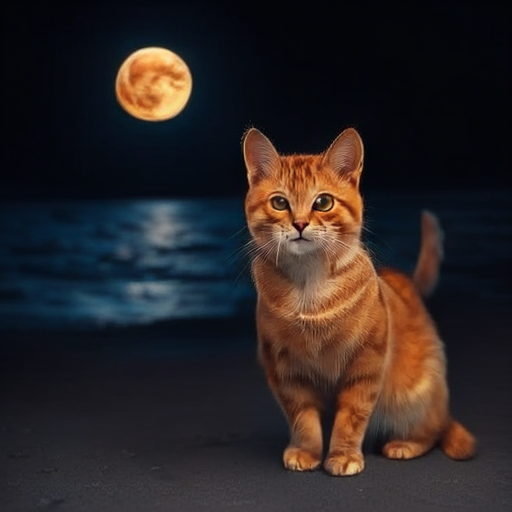

1it [00:49, 49.20s/it]

图片已保存为test3_1.png


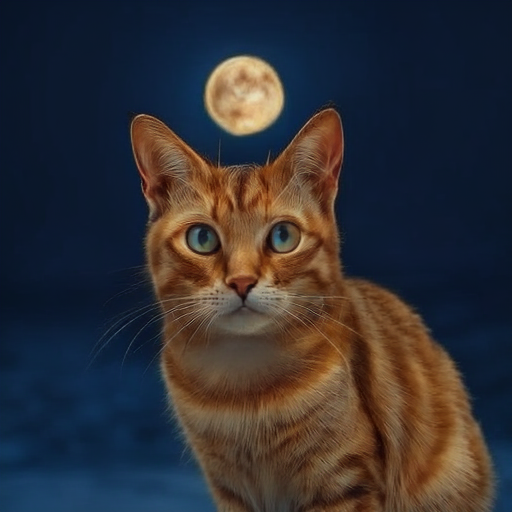

2it [01:38, 49.01s/it]

图片已保存为test3_2.png


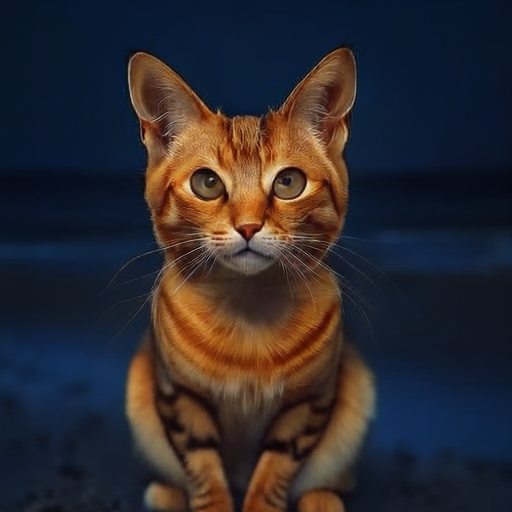

3it [02:27, 49.34s/it]

图片已保存为test3_3.png


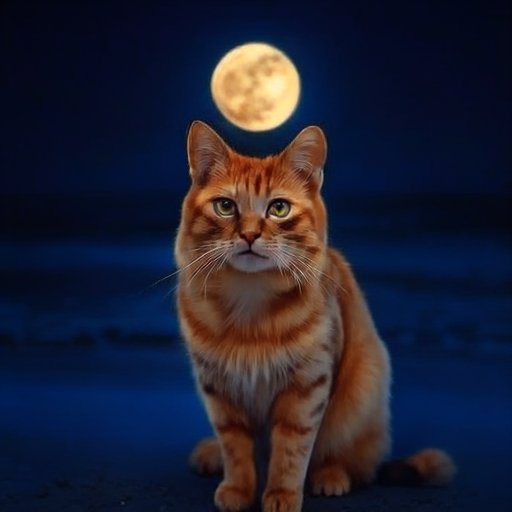

4it [03:17, 49.40s/it]

图片已保存为test3_4.png


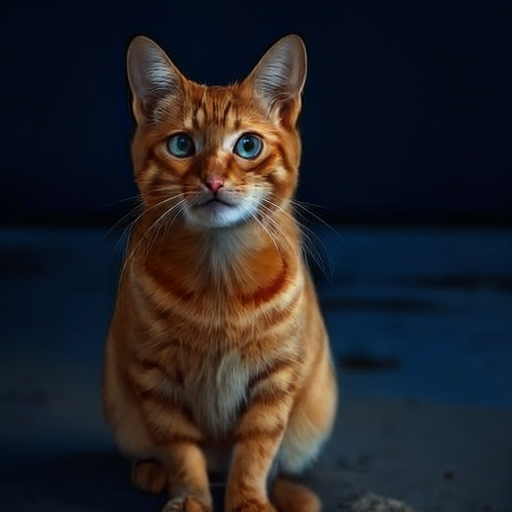

5it [04:06, 49.42s/it]

图片已保存为test3_5.png


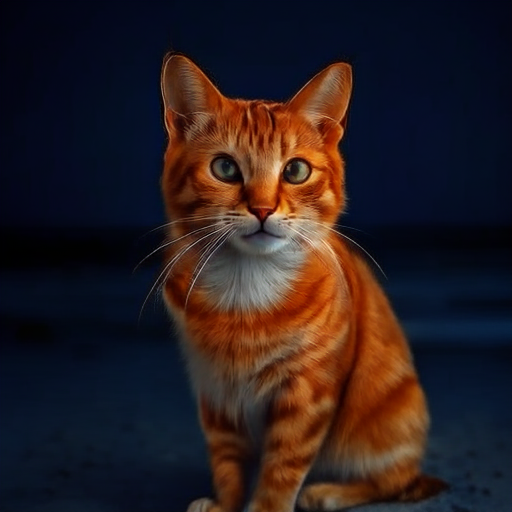

6it [04:56, 49.57s/it]

图片已保存为test3_6.png


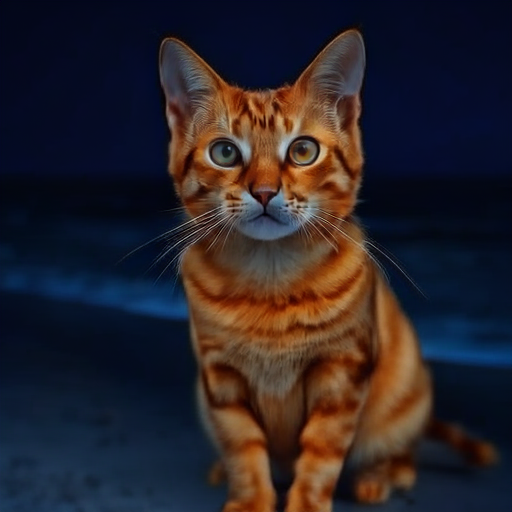

7it [05:46, 49.75s/it]

图片已保存为test3_7.png


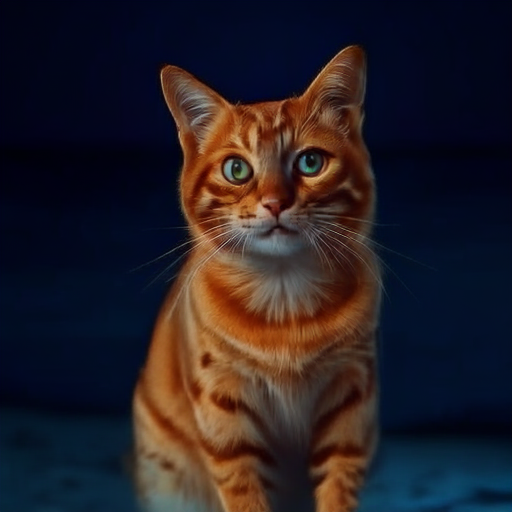

8it [06:36, 49.63s/it]

图片已保存为test3_8.png


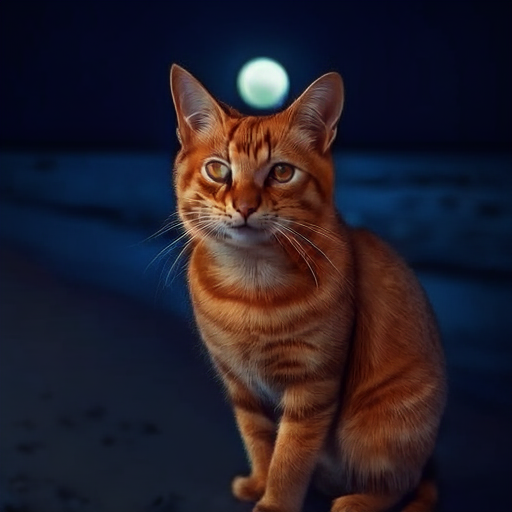

9it [07:25, 49.52s/it]

图片已保存为test3_9.png


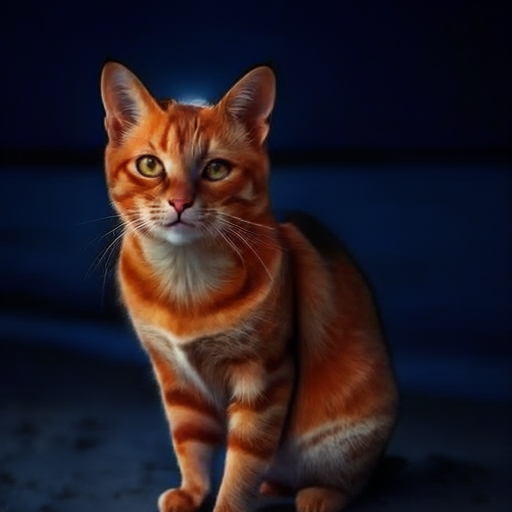

10it [08:14, 49.49s/it]

图片已保存为test3_10.png


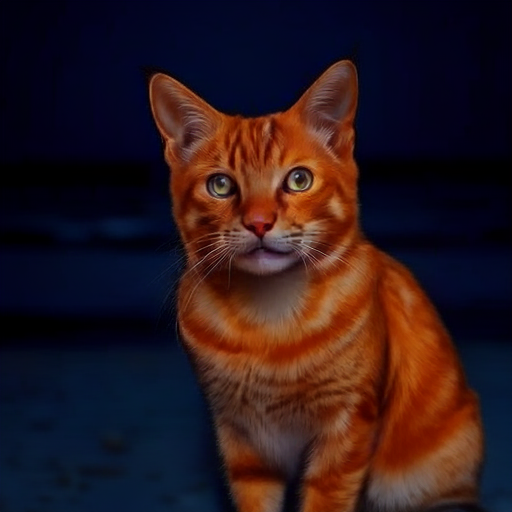

11it [09:04, 49.47s/it]

图片已保存为test3_11.png


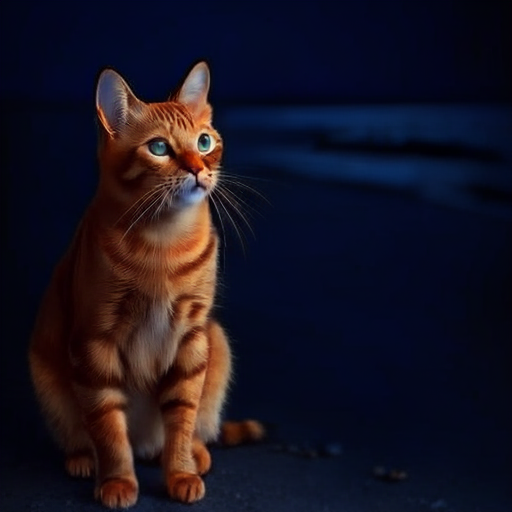

12it [09:53, 49.46s/it]

图片已保存为test3_12.png


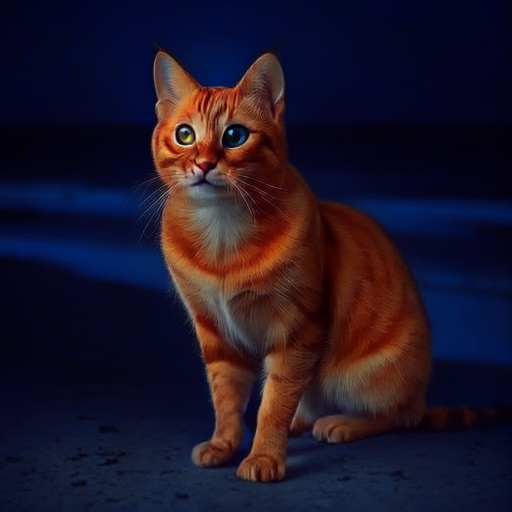

13it [10:43, 49.48s/it]

图片已保存为test3_13.png


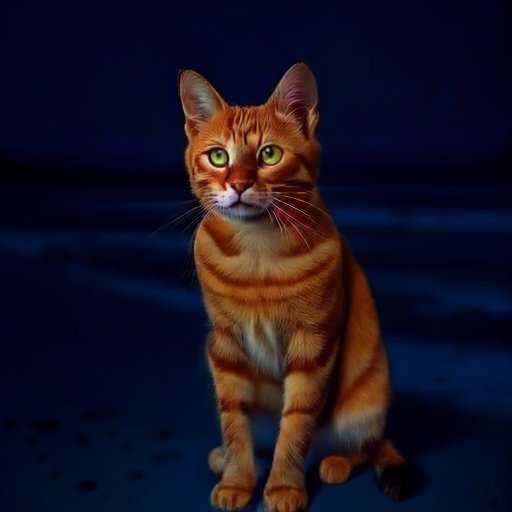

14it [11:32, 49.56s/it]

图片已保存为test3_14.png


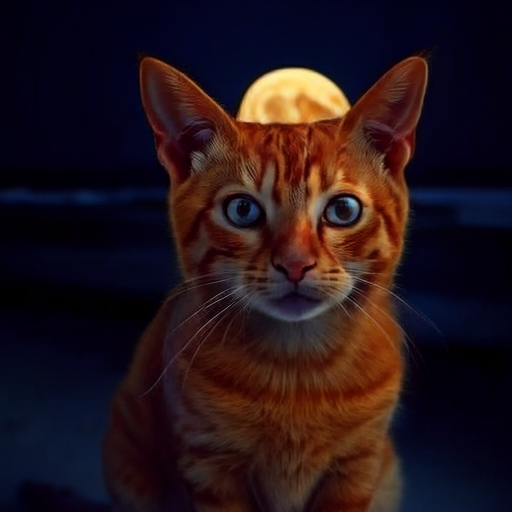

15it [12:22, 49.51s/it]


In [4]:
with torch.no_grad():

    each = {
        "global_idx": 0,
        "source_image": "/tmp/haozhezhao/MLLMG/temp.png",
        "image_path": ["/tmp/haozhezhao/MLLMG/cat.png", "/tmp/haozhezhao/MLLMG/beach.png"],
        "objects": ["cat", "beach"],
        "segment_idx": 0,
        "input_text": "A cat is sitting on the beach"
    }

    # 处理文本信息，获取输入文本和 token 信息
    input_text, text_input_ids, text_attention_mask = process_text_info(each, args)
    # 处理图像：加载 source image 及 masks（这里返回 source image 和 masks 列表）
    img, source_image = process_objects(each)
    
    # 使用模型内置的 processor（这里用 dummy_processor 模拟）
    
    process_data = eval_model.multimodal_processor(
        images=source_image,
        max_length=120,
        text=input_text,
        padding='max_length',
        truncation=True,
        return_attention_mask=True,
        add_special_tokens=True,
        return_tensors="pt"
    )
    
    # 注意：这里为了演示，pixel_values 先加了一个维度再调用 to(device)
    pixel_values = process_data['pixel_values'].unsqueeze(0)
    image_mask = torch.ones((pixel_values.shape[1]), dtype=torch.bool)
    cond_idx = process_data['input_ids'].squeeze(0)
    attention_mask = process_data['attention_mask'].squeeze(0)
    
    text_input_ids = text_input_ids.to(device, non_blocking=True)
    text_attention_mask = text_attention_mask.to(device, non_blocking=True)
    pixel_values = pixel_values.to(device, ptdtype, non_blocking=True)
    image_mask = image_mask.to(device, ptdtype, non_blocking=True)
    image_mask = image_mask.unsqueeze(0)
    text_input_ids = text_input_ids.unsqueeze(0)
    text_attention_mask = text_attention_mask.unsqueeze(0)
    # 为 source_image 创建 tensor（用 transforms 转换）
    # source_image_tensor = transforms.ToTensor()(source_image).unsqueeze(0).to(device, ptdtype, non_blocking=True)
    cond_idx = cond_idx.to(device, non_blocking=True)
    attention_mask = attention_mask.to(device, non_blocking=True)
    cond_idx = cond_idx.unsqueeze(0)
    attention_mask = attention_mask.unsqueeze(0)
    # 获取多模态 embedding



    # 获取多模态 embedding
    caption_embs = eval_model.get_multmodal_embeddings(
        pixel_values=pixel_values,
        cond_idx=cond_idx,
        cond_idx_mask=attention_mask,
        img_mask=image_mask,
        text_input_ids=text_input_ids,
        text_attention_mask=text_attention_mask
    )
    emb_masks = attention_mask
    
    if not args.no_left_padding:
        print("processing left-padding...")
        new_emb_masks = torch.flip(emb_masks, dims=[-1])
        new_caption_embs = []
        # 注意：这里简单处理，将 emb_masks 扩充 batch 维度方便迭代
        for idx, (caption_emb, emb_mask) in enumerate(zip(caption_embs, emb_masks.unsqueeze(0))):
            valid_num = int(emb_mask.sum().item())
            new_caption_emb = torch.cat([caption_emb[valid_num:], caption_emb[:valid_num]])
            new_caption_embs.append(new_caption_emb)
        new_caption_embs = torch.stack(new_caption_embs)
    else:
        new_caption_embs, new_emb_masks = caption_embs, emb_masks
    
    new_c_indices = new_caption_embs * new_emb_masks.unsqueeze(-1)
    c_emb_masks = new_emb_masks
    qzshape = [len(new_c_indices), args.codebook_embed_dim, latent_size, latent_size]
    for idx, cfg in tqdm(enumerate([x * 0.5 for x in range(int(7.5 / 0.5) + 1) if x != 0])):
        index_sample = generate(
            eval_model, new_c_indices, latent_size ** 2,
            c_emb_masks,
            cfg_scale=cfg,
            temperature=args.temperature, top_k=args.top_k,
            top_p=args.top_p, sample_logits=True,
        )
        
        if index_sample.shape[0] == 1:
            output = vq_model.decode_code(index_sample, qzshape)
        else:
            outputs = []
            for each_sample in index_sample:
                qzshape_sample = [1, args.codebook_embed_dim, latent_size, latent_size]
                outputs.append(vq_model.decode_code(each_sample.unsqueeze(0), qzshape_sample))
            output = torch.cat(outputs, dim=0)
        
        # 保存生成的图片
        save_image(output, f"test3_{idx}.png", normalize=True,
                                           value_range=(-1, 1))
        print(f"图片已保存为test3_{idx}.png")
        # show PIL image
        image = Image.open(f"test3_{idx}.png")
        image.show()

[0.5, 1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0, 4.5, 5.0, 5.5, 6.0, 6.5, 7.0, 7.5]